In [2]:
import torch
import torch.nn as nn
import torchtext.data as ttd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import spacy
import re

In [3]:
from nltk.corpus import stopwords

In [4]:
from datetime import datetime

## Load data

In [5]:
df = pd.read_csv('spammail.csv')

In [7]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


## Map label to ham: 0 | spam: 1

In [9]:
df.label = df.label.map({'ham': 0, 'spam':1})

In [10]:
df

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [11]:
df.to_csv('spam_maped_label.csv', index=False)

## Data Preprocessing

In [12]:
lematizer = WordNetLemmatizer()
spacy_en = spacy.load("en_core_web_sm")
stopwords = set(stopwords.words('english'))
def text_preprocessing(text):
    # Delete special punctuation
    tokens = re.sub(r'[^a-zA-Z]+', ' ', text.strip())
    # use spacy and WordNetLemmatizer to tokenize and remove part of speech
    tokens = [token.text.lower() for token in spacy_en.tokenizer(tokens)]
    tokens = [lematizer.lemmatize(token, pos='v') for token in tokens if token not in stopwords]
    return tokens

## Define data

In [13]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=True, 
    tokenize=text_preprocessing
)

LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

In [14]:
dataset = ttd.TabularDataset(
    path='spam_maped_label.csv',
    format='csv',
    skip_header=True,
    fields=[('label', LABEL), ('message', TEXT)]
)

In [15]:
dataset.examples[0].message

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'get',
 'amore',
 'wat']

# SPLIT DATA

In [16]:
# Build in function of ttd. Default : 70%
train_dataset, test_dataset = dataset.split()

In [17]:
len(train_dataset)

3900

In [18]:
print(vars(train_dataset[0]))

{'label': '0', 'message': ['come', 'friday', 'leave', 'pongal', 'get', 'news', 'work', 'place']}


## Word embedding

In [19]:
TEXT.build_vocab(train_dataset,)

In [20]:
vocab = TEXT.vocab

In [21]:
# vocab.stoi

## Use Gpu

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [24]:
train_iterator, test_iterator = ttd.Iterator.splits(
    (train_dataset, test_dataset),
    sort_key = lambda x : len(x.message),
    batch_sizes=(32, 256),
    device=device
)

In [25]:
for inputs, targets in train_iterator:
    print(inputs.shape, targets.shape)
    break

torch.Size([32, 21]) torch.Size([32])


In [ ]:
## Create class RNN inherit nn.Module

# Note: Model is a Module. All units in nn (Sequential, Linerar, Relu...) are modules
# All inherits Module

In [26]:
class RNN(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.V = n_vocab
        self.D = embed_dim
        self.M = n_hidden
        self.L = n_rnnlayers
        self.K = n_outputs

        self.embed = nn.Embedding(self.V, self.D)
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers= self.L,
            batch_first = True
        )

        self.fc = nn.Linear(self.M, self.K)

    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        
        out = self.embed(X)
        out, _ = self.rnn(out, (h0, c0))
        out, _ = torch.max(out, 1)
        out = self.fc(out)
        return out

## Create model and bring to gpu

In [28]:
model = RNN(len(vocab), 20, 15, 1, 1)
model.to(device)

RNN(
  (embed): Embedding(5446, 20)
  (rnn): LSTM(20, 15, batch_first=True)
  (fc): Linear(in_features=15, out_features=1, bias=True)
)

## Loss and gradient descent

In [29]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define batch gradient descent function

In [ ]:
def batch_grad(model, criterion, optimizer, train_iterator, test_iterator, epochs=20):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    for it in range(epochs):
        train_loss = []
        t0 = datetime.now()
        for inputs, targets in train_iterator:
            targets = targets.view(-1, 1).float()
            
            # zero weights
            optimizer.zero_grad()
            
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
        train_loss = np.mean(train_loss)

        test_loss = []
        for inputs, targets in test_iterator:
            targets = targets.view(-1, 1).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)
        train_losses[it], test_losses[it] = train_loss, test_loss
        dt = datetime.now() - t0
        print(f'Epoch: {it + 1}/{epochs} train loess: {train_loss:.4f}  test loss" {test_loss:.4f}  duration: {dt}')

    return train_losses, test_losses

# Train model

In [31]:
train_losses, test_losses = batch_grad(model, criterion, optimizer, train_iterator, test_iterator, epochs=20) 

Epoch: 1/20 train loess: 0.4293  test loss" 0.4867  duration: 0:00:00.987857
Epoch: 2/20 train loess: 0.3703  test loss" 0.5145  duration: 0:00:00.498551
Epoch: 3/20 train loess: 0.3401  test loss" 0.4504  duration: 0:00:00.475893
Epoch: 4/20 train loess: 0.2581  test loss" 0.3713  duration: 0:00:00.454258
Epoch: 5/20 train loess: 0.1829  test loss" 0.3434  duration: 0:00:00.463158
Epoch: 6/20 train loess: 0.1510  test loss" 0.3229  duration: 0:00:00.492278
Epoch: 7/20 train loess: 0.1186  test loss" 0.3144  duration: 0:00:00.481091
Epoch: 8/20 train loess: 0.0998  test loss" 0.3157  duration: 0:00:00.531639
Epoch: 9/20 train loess: 0.0883  test loss" 0.2887  duration: 0:00:00.501032
Epoch: 10/20 train loess: 0.0826  test loss" 0.3101  duration: 0:00:00.527409
Epoch: 11/20 train loess: 0.0703  test loss" 0.3093  duration: 0:00:00.540811
Epoch: 12/20 train loess: 0.0625  test loss" 0.3107  duration: 0:00:00.648187
Epoch: 13/20 train loess: 0.0572  test loss" 0.3114  duration: 0:00:00.62

# PLot loss

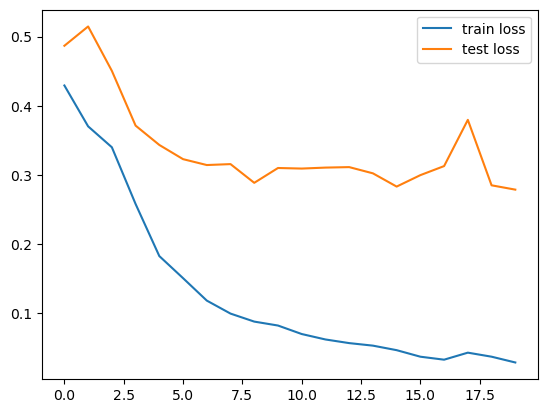

In [32]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend();

# Evalutating with accuracy

In [255]:
p_train = []
y_train = []
for inputs, targets in train_iterator:
    targets = targets.view(-1, 1).float()
    outputs = model(inputs)

    # prediction
    predictions = list((outputs > 0).cpu().numpy())

    p_train += predictions
    y_train += list(targets.cpu().numpy())

p_train = np.array(p_train)
y_train = np.array(y_train)

train_acc = np.mean(y_train == p_train)

p_test = []
y_test = []
for inputs, targets in test_iterator:
    targets = targets.view(-1, 1).float()
    outputs = model(inputs)
    # print(outputs)
    # prediction
    predictions = list((outputs > 0).cpu().numpy())
    # print(predictions)
    p_test += predictions
    y_test += list(targets.cpu().numpy())

p_test = np.array(p_test)
y_test = np.array(y_test)

test_acc = np.mean(y_test == p_test)
print(f'train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}')

train_acc: 0.9949, test_acc: 0.8840


In [36]:
import seaborn as sns

In [37]:
from sklearn.metrics import confusion_matrix

def plot_cm(cm, title='cm'):
    sns.heatmap(cm, annot=True, fmt='d', cbar=True)
    plt.title(title)
    plt.ylabel('predicted')
    plt.xlabel('true label')
    plt.show()

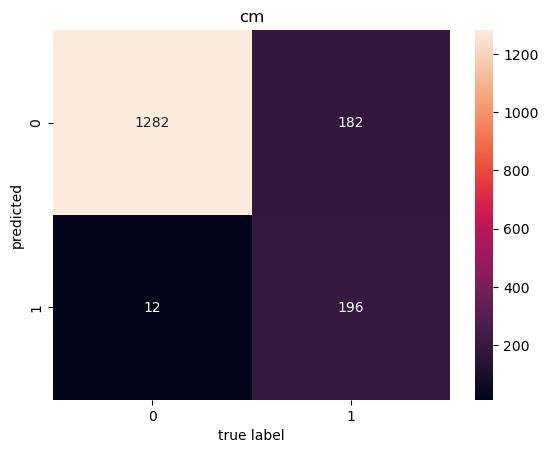

In [47]:
cm = confusion_matrix(y_test, p_test)
plot_cm(cm)

# Predict

## Single prediction

In [248]:
single_sentc =  'hello can you come tonight?'
tokens = TEXT.numericalize([TEXT.preprocess(single_sentc)])
output = model(tokens.to(device))  # Đưa vào mô hình
print('Spam' if output > 0 else 'ham')

ham


In [251]:
single_sentc =  'You have been selected to receive a $10,000 gift card from our exclusive rewards program!'
tokens = TEXT.numericalize([TEXT.preprocess(single_sentc)])
output = model(tokens.to(device))  # Đưa vào mô hình
print('Spam' if output > 0 else 'ham')

Spam


## Multiple prediction

In [179]:
sample_dataset = ttd.TabularDataset(
    path='test_data.csv',
    format='csv',
    skip_header=True,
    fields=[('label', LABEL),('message', TEXT)]
)

In [181]:
sample_dataset.examples[0].label

'1'

In [183]:
sample_iterator = ttd.Iterator(
    sample_dataset,
    batch_size=32,
    sort_key= lambda x : len(x.message),
    device=device
)